# Objective : 
Apply logistic regression on Amazon review dataset to find accuracy and error of diffrent models.

## Workflow:
1. Sort data based on time.
2. Split data into train and test.
3. Convert reviews of "Amazon Fine Food Review" dataset into vectors using :-
    * Bag of words.
    * TF-IDF
    * Average Word2vec
    * TF-IDF Word2ves 
4. Perform standardization on every vectorized data.
5. Find best hyperparameter(lamda) by GridSearchCV and RandomizedSearchCV.
6. Apply Logistic Regression in diffrent models using L1 and L2 regularizer.
7. Find accuracy and error of the model.
8. Print confusion matrix and plot error plots for every model. 
9. Find colinearity between features.
10. Find top n important feature as per their weight vector.

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re, gensim
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn import cross_validation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import chi2, mutual_info_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
import copy

/home/dev/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/dev/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Importing data

In [2]:
"""
Reading data from .sqlite file,
choosing only positive and negative reviews not neutral reviews.
"""
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("SELECT * FROM Reviews WHERE Score != 3", con) 

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

## Cleansing data

In [3]:
"""
Below code snippet removes duplicate data from dataset that are repeatedly mentioned.
"""
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True,\
                                      inplace=False, kind='quicksort',\
                                      na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},\
                                  keep='first', inplace=False)
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [4]:
"""
Sorting data on the basis of TIME
"""
final = final[:100000]
final = final.sort_values(by=['Time'], axis=0)
final.shape

(100000, 10)

## Text preprocessing

In [5]:
"""
This code snippet does text preprocessing
"""
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
final_text = []
for index in range(len(final['Text'])):
    filtered_sentence=[]
    sent=cleanhtml(final['Text'].iloc[index]) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():# clean punctuation marks from words
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):# verifying word must be a alphabet and atleat two character long
                cleaned_words = cleaned_words.lower()
                if(cleaned_words not in stop):# blocks stopwords
                    s=(sno.stem(cleaned_words))# stemming in process
                    filtered_sentence.append(s)
                else:
                    continue
            else:
                continue 
    str1 = " ".join(filtered_sentence) #final cleaned string of words
    final_text.append(str1)

In [6]:
amazon_data_text = pd.Series(final_text)
amazon_data_label = pd.Series(final['Score'])
print(amazon_data_text.shape)
print(amazon_data_label.shape)

(100000,)
(100000,)


In [7]:
"""
Spliting sample data into train_data and test_data (75:25)
"""
x_train, x_test, y_train, y_test = cross_validation.train_test_split(\
                                                                     amazon_data_text,\
                                                                     amazon_data_label,\
                                                                     test_size = 0.25,\
                                                                     random_state=0)

In [8]:
print(y_test.value_counts())

positive    21253
negative     3747
Name: Score, dtype: int64


### Bag of words.

In [27]:
"""
This code snippet converts train data from text to vectors by BOW.
"""
count_vect = CountVectorizer(analyzer='word', dtype = 'float64') #in scikit-learn
bow_text_train_vector = count_vect.fit_transform(x_train)
bow_text_train_vector = bow_text_train_vector
bow_text_train_vector.shape

(75000, 32711)

In [28]:
"""
This code snippet converts test data from text to vectors by BOW.
"""
bow_text_test_vector = count_vect.transform(x_test)
bow_text_test_vector = bow_text_test_vector
print(bow_text_test_vector.shape)

(25000, 32711)


In [29]:
"""
Standardize both training and test data
"""
scale = StandardScaler(with_mean = False)
bow_text_train_vector = scale.fit_transform(bow_text_train_vector)
bow_text_test_vector  = scale.transform(bow_text_test_vector)
print("Train data shape :",bow_text_train_vector.shape)
print("Test data shape :",bow_text_test_vector.shape)

Train data shape : (75000, 32711)
Test data shape : (25000, 32711)


In [30]:
"""
This code snippet deals with GridSearchCV
"""
tuned_parameters = [{ 'C' : [10**-4, 10**-3, 10**-2,\
                             10**-1, 10**0, 10**1,\
                             10**2,10**3, 10**4]}]
f1_scorer = make_scorer(f1_score, pos_label="positive")
model = GridSearchCV(LogisticRegression(), tuned_parameters,\
                     scoring = f1_scorer, cv=5 )
model.fit(bow_text_train_vector, y_train)
print(model.best_estimator_)
print("F1 Score : ",model.score(bow_text_train_vector, y_train))

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
F1 Score :  0.9820719286586403


In [38]:
"""
This code snippet deals with RandomizedSearchCV
"""
parameters = { 'C' : uniform(10**-2,10**2)}
f1_scorer = make_scorer(f1_score, pos_label="positive")
model = RandomizedSearchCV(LogisticRegression(), parameters, scoring = f1_scorer, cv=5 )
model.fit(bow_text_train_vector, y_train)
print(model.best_estimator_)
print("F1 Score : ",model.score(bow_text_train_vector, y_train))

LogisticRegression(C=46.67064188978246, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
F1 Score :  0.9922409217222968


Sparsity :  32711
Error : 14.24


Text(0.5,1,'CONFUSION MATRIX')

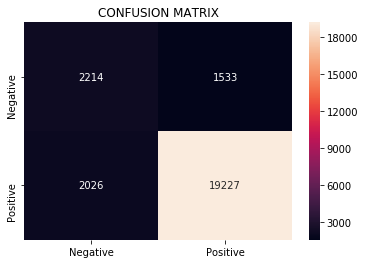

In [36]:
"""
In this code snippet finds sparsity and erorr using lamda from GridSearchCV.
"""
clf = LogisticRegression(C=1000, penalty='l2');
clf.fit(bow_text_train_vector, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(bow_text_test_vector)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  19941
Error : 13.19


Text(0.5,1,'CONFUSION MATRIX')

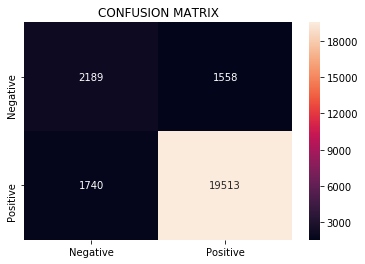

In [37]:
"""
In this code snippet finds sparsity and erorr using lamda from GridSearchCV.
"""
clf = LogisticRegression(C=1000, penalty='l1');
clf.fit(bow_text_train_vector, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(bow_text_test_vector)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  32711
Error : 10.53


Text(0.5,1,'CONFUSION MATRIX')

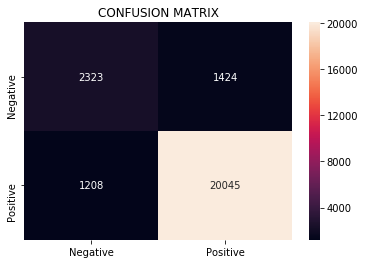

In [47]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.02, penalty='l2');
clf.fit(bow_text_train_vector, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(bow_text_test_vector)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

In [87]:
"""Lists to store lambda and error values"""
lambda_list = [0.02,0.002,0.0002]
train_error = []
test_error = []

Sparsity :  6351
Error : 8.31


Text(0.5,1,'CONFUSION MATRIX')

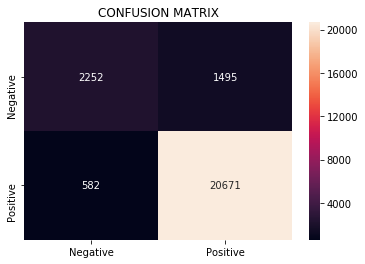

In [88]:
"""
In this code snippet finds sparsity and test erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.02, penalty='l1');
clf.fit(bow_text_train_vector, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(bow_text_test_vector)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 4.41


Text(0.5,1,'CONFUSION MATRIX')

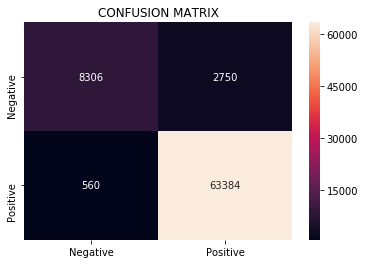

In [89]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(bow_text_train_vector)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  216
Error : 10.90


Text(0.5,1,'CONFUSION MATRIX')

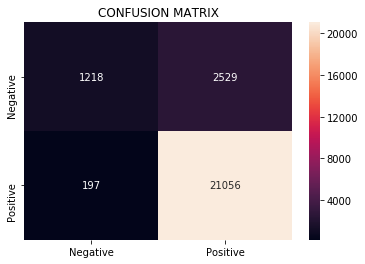

In [90]:
"""
In this code snippet finds sparsity and test erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.002, penalty='l1');
clf.fit(bow_text_train_vector, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(bow_text_test_vector)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 10.70


Text(0.5,1,'CONFUSION MATRIX')

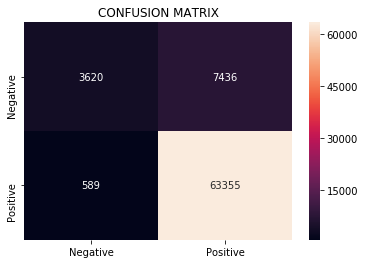

In [91]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(bow_text_train_vector)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  2
Error : 14.99


Text(0.5,1,'CONFUSION MATRIX')

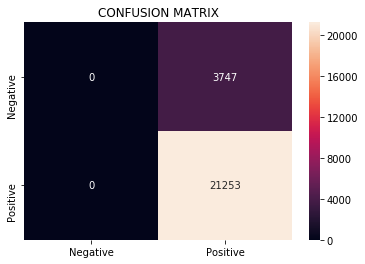

In [92]:
"""
In this code snippet finds sparsity and test erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.0002, penalty='l1');
clf.fit(bow_text_train_vector, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(bow_text_test_vector)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 14.74


Text(0.5,1,'CONFUSION MATRIX')

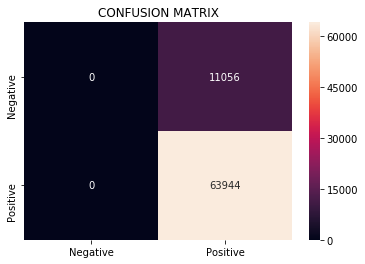

In [93]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(bow_text_train_vector)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

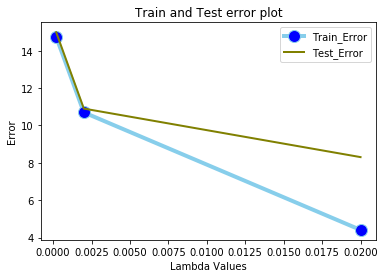

In [114]:
Train_Error, = plt.plot( lambda_list, train_error, marker='o',\
                        markerfacecolor='blue', markersize=12,\
                        color='skyblue', linewidth=4)
Test_Error,  = plt.plot( lambda_list, test_error, marker='',\
                        color='olive', linewidth=2)
plt.xlabel('Lambda Values')
plt.ylabel('Error')
plt.title('Train and Test error plot')
plt.legend([Train_Error,Test_Error], ["Train_Error","Test_Error"])
plt.show()

In [51]:
"""
This code snippet shows effect of colinearity of on weight vectors
"""
x = copy.deepcopy(bow_text_train_vector)

clf = LogisticRegression(C=0.02, penalty='l1');
clf.fit(bow_text_train_vector, y_train);
w = clf.coef_
a = np.transpose(np.nonzero(w))
print("Weight vector before perturbation :", end=" ")
for i,j in a[:20]:
    print("%.5f"%w[i,j], end=" ")
    
print("\n")

# perturbation technique start
epsilon = np.random.normal(loc=0.0, scale=0.01)
a = np.transpose(np.nonzero(x))
for i,j in a:
    x[i,j] += epsilon
# perturbation technique end

clf = LogisticRegression(C=0.02, penalty='l1');
clf.fit(x, y_train);
w = clf.coef_
a = np.transpose(np.nonzero(w))
print("Weight vector after perturbation :", end=" ")
for i,j in a[:20]:
    print("%.5f"%w[i,j], end=" ")

# deleting the variable to free RAM
del x

Weight vector before perturbation : 0.00113 0.00005 -0.02143 0.00931 0.00431 -0.00209 -0.01079 0.00251 -0.00432 0.01037 0.00018 -0.00800 -0.00491 0.00759 -0.00194 0.00195 0.00301 0.00473 -0.03265 0.01044 

Weight vector after perturbation : 0.00304 -0.02144 0.00932 0.00430 -0.00209 -0.01079 0.00250 -0.00432 0.01036 0.00066 -0.00801 -0.00491 0.00757 -0.00193 0.00192 0.01056 0.00473 -0.03264 0.01044 0.00734 

In [72]:
"""
This code snippet prints top 10 important features along with there index no
"""
clf = LogisticRegression(C=0.02, penalty='l1');
clf.fit(bow_text_train_vector, y_train);
w = clf.coef_
a = [i for i in sorted(enumerate(w[0]),key=lambda pair: pair[1], reverse = True) if i[1] != 0.0]
print("FeatureIndex  FeatureWeight\n")
print(*a[:10],sep = '\n')

FeatureIndex  FeatureWeight

(12204, 0.7289452936016304)
(16718, 0.5963629686574519)
(2604, 0.5603180499523812)
(7368, 0.44692751917682194)
(11931, 0.3870590135613957)
(21179, 0.3845441773177839)
(9631, 0.38398177379327353)
(19256, 0.26993894477896646)
(899, 0.26085363814539275)
(10053, 0.25132080217345454)


#### Observation :
* Here we have applied Bag of words to convert text to vector.
* We got hyperparameter(lambda) from GridSearchCV is 0.001 and from RandomizedSearchCV is 46.67.
* I got best result from a model where C = 0.02 (i.e. lambda = 46.67), sparsity = 6351 and the minimum test error 8.31.
* Colinearity is also not affecting much to features.

### TF IDF.

In [22]:
"""
This code snippet converts train data from text to vectors by TF_IDF.
"""
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf_train = tf_idf_vect.fit_transform(x_train)
final_tf_idf_train.shape

(75000, 1002260)

In [23]:
"""
This code snippet converts test data from text to vectors by TF_IDF.
"""
final_tf_idf_test = tf_idf_vect.transform(x_test)
final_tf_idf_test.shape

(25000, 1002260)

In [24]:
"""
Standardize both training and test data
"""
scale = StandardScaler(with_mean = False)
final_tf_idf_train = scale.fit_transform(final_tf_idf_train)
final_tf_idf_test  = scale.transform(final_tf_idf_test)
print("Train data shape : ",final_tf_idf_train.shape)
print("Test data shape : ",final_tf_idf_test.shape)

Train data shape :  (75000, 1002260)
Test data shape :  (25000, 1002260)


In [25]:
"""
This code snippet deals with GridSearchCV
"""
tuned_parameters = [{ 'C' : [10**-4, 10**-3, 10**-2,\
                             10**-1, 10**0, 10**1,\
                             10**2,10**3, 10**4]}]
f1_scorer = make_scorer(f1_score, pos_label="positive")
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = f1_scorer, cv=5 )
model.fit(final_tf_idf_train, y_train)
print(model.best_estimator_)
print("F1 Score : ",model.score(final_tf_idf_train, y_train))

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
F1 Score :  1.0


In [41]:
"""
This code snippet deals with RandomizedSearchCV
"""
parameters = { 'C' : uniform(10**-2,10**2)}
f1_scorer = make_scorer(f1_score, pos_label="positive")
model = RandomizedSearchCV(LogisticRegression(), parameters, scoring = f1_scorer, cv=5 )
model.fit(final_tf_idf_train, y_train)
print(model.best_estimator_)
print("F1 Score : ",model.score(final_tf_idf_train, y_train))

LogisticRegression(C=59.673280620372125, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
F1 Score :  1.0


Sparsity :  1002260
Error : 11.91


Text(0.5,1,'CONFUSION MATRIX')

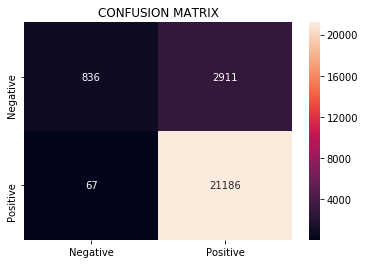

In [39]:
"""
In this code snippet finds sparsity and erorr using lamda from GridSearchCV.
"""
clf = LogisticRegression(C=0.001, penalty='l2');
clf.fit(final_tf_idf_train, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(final_tf_idf_test)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  108
Error : 11.88


Text(0.5,1,'CONFUSION MATRIX')

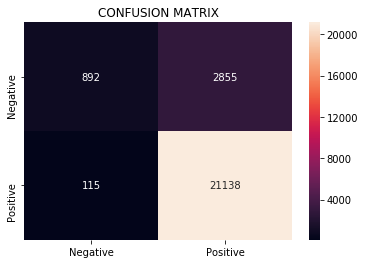

In [40]:
"""
In this code snippet finds sparsity and erorr using lamda from GridSearchCV.
"""
clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(final_tf_idf_train, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(final_tf_idf_test)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  1002260
Error : 11.69


Text(0.5,1,'CONFUSION MATRIX')

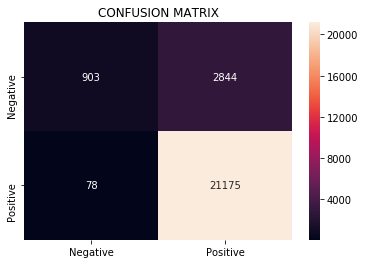

In [53]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.016, penalty='l2');
clf.fit(final_tf_idf_train, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(final_tf_idf_test)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

In [156]:
"""Lists to store lambda and error values"""
lambda_list = [0.02,0.002,0.0002]
train_error = []
test_error = []

Sparsity :  32487
Error : 8.21


Text(0.5,1,'CONFUSION MATRIX')

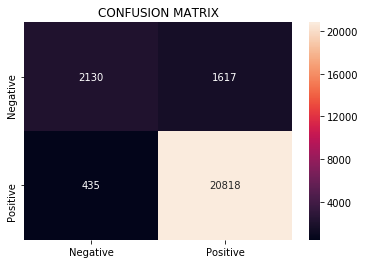

In [157]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.016, penalty='l1');
clf.fit(final_tf_idf_train, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(final_tf_idf_test)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 0.00


Text(0.5,1,'CONFUSION MATRIX')

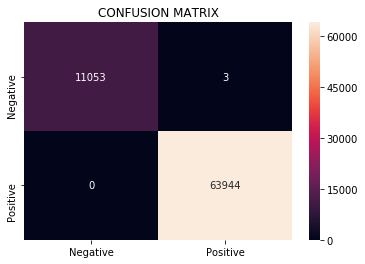

In [158]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(final_tf_idf_train)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  10722
Error : 8.07


Text(0.5,1,'CONFUSION MATRIX')

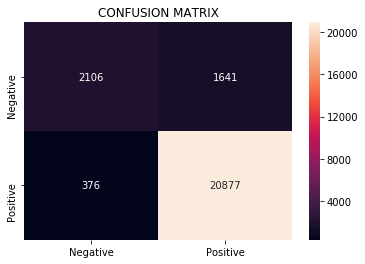

In [159]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.005, penalty='l1');
clf.fit(final_tf_idf_train, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(final_tf_idf_test)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 6.27


Text(0.5,1,'CONFUSION MATRIX')

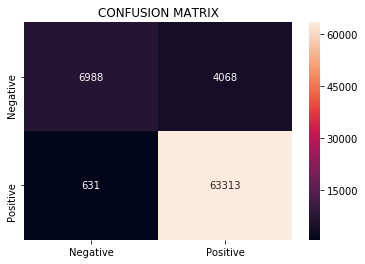

In [160]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(final_tf_idf_train)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  108
Error : 11.88


Text(0.5,1,'CONFUSION MATRIX')

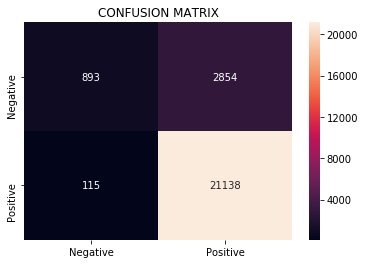

In [161]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(final_tf_idf_train, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(final_tf_idf_test)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 12.09


Text(0.5,1,'CONFUSION MATRIX')

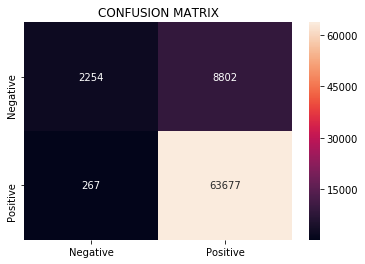

In [162]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(final_tf_idf_train)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

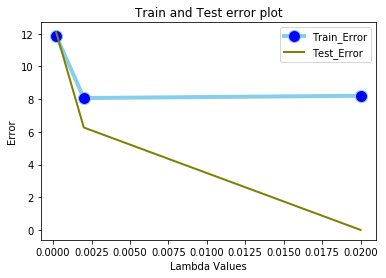

In [163]:
Train_Error, = plt.plot( lambda_list, train_error, marker='o',\
                        markerfacecolor='blue', markersize=12,\
                        color='skyblue', linewidth=4)
Test_Error,  = plt.plot( lambda_list, test_error, marker='',\
                        color='olive', linewidth=2)
plt.xlabel('Lambda Values')
plt.ylabel('Error')
plt.title('Train and Test error plot')
plt.legend([Train_Error,Test_Error], ["Train_Error","Test_Error"])
plt.show()

In [57]:
"""
This code snippet shows effect of colinearity of on weight vectors
"""
x = copy.deepcopy(final_tf_idf_train)

clf = LogisticRegression(C=0.016, penalty='l1');
clf.fit(final_tf_idf_train, y_train);
w = clf.coef_
a = np.transpose(np.nonzero(w))
print("Weight vector before perturbation :", end=" ")
for i,j in a[:20]:
    print("%.5f"%w[i,j], end=" ")

print("\n")

# perturbation technique start
epsilon = np.random.normal(loc=0.0, scale=0.01)
a = np.transpose(np.nonzero(x))
for i,j in a:
    x[i,j] += epsilon
# perturbation technique end

clf = LogisticRegression(C=0.016, penalty='l1');
clf.fit(x, y_train);
w = clf.coef_
a = np.transpose(np.nonzero(w))
print("Weight vector after perturbation :", end=" ")
for i,j in a[:20]:
    print("%.5f"%w[i,j], end=" ")

# deleting the variable to free RAM
del x

Weight vector before perturbation : -0.00000 0.00063 -0.00002 -0.00190 -0.00002 -0.00111 -0.00042 -0.00001 -0.00678 -0.00096 -0.00185 -0.00769 -0.00086 -0.00534 -0.00043 -0.00478 0.00114 -0.00001 -0.00059 0.00021 

Weight vector after perturbation : 0.00001 0.00045 -0.00019 -0.00011 -0.00029 -0.00049 -0.00003 -0.00165 -0.00149 -0.00677 0.00002 -0.00709 -0.00197 -0.00777 -0.00097 -0.00023 -0.00532 -0.00465 0.00068 -0.00033 

In [58]:
"""
This code snippet prints top 10 important features along with there index no
"""
clf = LogisticRegression(C=0.016, penalty='l1');
clf.fit(final_tf_idf_train, y_train);
w = clf.coef_
a = [i for i in sorted(enumerate(w[0]),key=lambda pair: pair[1], reverse = True) if i[1] != 0.0]
print("FeatureIndex  FeatureWeight\n")
print(*a[:10],sep = '\n')

FeatureIndex  FeatureWeight

(387933, 0.785934372969754)
(516162, 0.6364985687573737)
(78206, 0.5743342190942607)
(230440, 0.4394084060182864)
(377923, 0.3935776519903513)
(641873, 0.3700703693077426)
(298018, 0.33521021298916326)
(418383, 0.30591197107353496)
(584950, 0.25422810437674453)
(316225, 0.24908671617036693)


#### Observation:
* Here we have applied TF IDF to convert text to vector.
* We got hyperparameter(lambda) from GridSearchCV is 1000 and from RandomizedSearchCV is 59.67 .
* I got best result from a model where C = 0.016 (i.e. lambda = 59.67), sparsity = 32846 and the minimum error 8.21 .
* Colinearity is also not affecting much to features.

## 3) Word2Vec

In [10]:
"""
Creating own vocabulary of words from reviews.
"""
i=0
list_of_train_sent=[]
for sent in x_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_train_sent.append(filtered_sentence)
w2v_train_model=gensim.models.Word2Vec(list_of_train_sent,
                                       min_count=5,size=50,
                                       workers=4)
i=0
list_of_test_sent=[]
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_test_sent.append(filtered_sentence)
w2v_test_model=gensim.models.Word2Vec(list_of_test_sent,min_count=5,size=50, workers=4) 

### a) Average Word2Vec

In [17]:
"""
This code snippet converts train data from text to vectors by Average Word2Vec
"""
# compute average word2vec for each review.
tain_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_train_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words == 0:
        cnt_words = 1
    sent_vec /= cnt_words
    tain_vectors.append(sent_vec)
train_avg_w2v = np.asmatrix(tain_vectors)
train_avg_w2v.shape

(75000, 50)

In [18]:
"""
This code snippet converts test data from text to vectors by Average Word2Vec
"""
# compute average word2vec for each review.
test_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_test_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_test_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    if cnt_words == 0:
        cnt_words = 1
    sent_vec /= cnt_words
    test_vectors.append(sent_vec)
test_avg_w2v = np.asmatrix(test_vectors)
test_avg_w2v.shape

(25000, 50)

In [19]:
"""
Standardize both training and test data
"""
scale = StandardScaler(with_mean = False)
train_avg_w2v = scale.fit_transform(train_avg_w2v)
test_avg_w2v  = scale.transform(test_avg_w2v)
print("Train data shape : ",train_avg_w2v.shape)
print("Test data shape : ",test_avg_w2v.shape)

Train data shape :  (75000, 50)
Test data shape :  (25000, 50)


In [32]:
import pickle
pickle_out = open("train_avg_w2v.pkl", "wb")
pickle.dump(train_avg_w2v, pickle_out)
pickle_out.close()
pickle_out = open("test_avg_w2v.pkl", "wb")
pickle.dump(test_avg_w2v, pickle_out)
pickle_out.close()

In [20]:
"""
This code snippet deals with GridSearchCV
"""
tuned_parameters = [{ 'C' : [10**-4, 10**-3, 10**-2,\
                             10**-1, 10**0, 10**1,\
                             10**2,10**3, 10**4]}]
f1_scorer = make_scorer(f1_score, pos_label="positive")
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = f1_scorer, cv=5 )
model.fit(train_avg_w2v, y_train)
print(model.best_estimator_)
print("F1 Score : ",model.score(train_avg_w2v, y_train))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
F1 Score :  0.939383132895785


In [42]:
"""
This code snippet deals with RandomizedSearchCV
"""
parameters = { 'C' : uniform(10**-3,10**3)}
f1_scorer = make_scorer(f1_score, pos_label="positive")
model = RandomizedSearchCV(LogisticRegression(), parameters, scoring = f1_scorer, cv=5 )
model.fit(train_avg_w2v, y_train)
print(model.best_estimator_)
print("F1 Score : ",model.score(train_avg_w2v, y_train))

LogisticRegression(C=804.0099703308456, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
F1 Score :  0.939357149361095


Sparsity :  50
Error : 13.42


Text(0.5,1,'CONFUSION MATRIX')

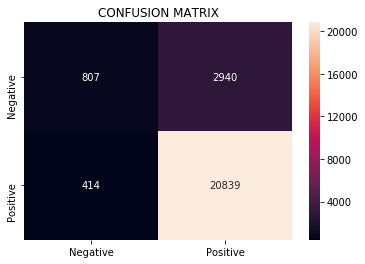

In [43]:
"""
In this code snippet finds sparsity and erorr using lamda from GridSearchCV.
"""
clf = LogisticRegression(C=1, penalty='l2');
clf.fit(train_avg_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_avg_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  50
Error : 13.32


Text(0.5,1,'CONFUSION MATRIX')

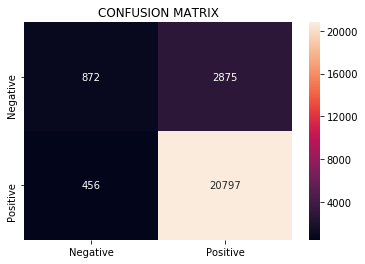

In [44]:
"""
In this code snippet finds sparsity and erorr using lamda from GridSearchCV.
"""
clf = LogisticRegression(C= 1, penalty='l1');
clf.fit(train_avg_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_avg_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  50
Error : 13.18


Text(0.5,1,'CONFUSION MATRIX')

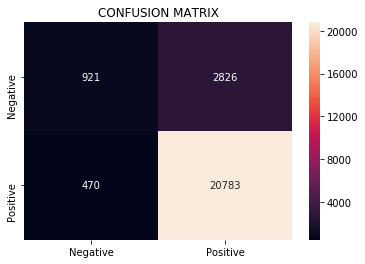

In [59]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.001, penalty='l2');
clf.fit(train_avg_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_avg_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

In [177]:
"""Lists to store lambda and error values"""
lambda_list = [0.02,0.002,0.0002]
train_error = []
test_error = []

Sparsity :  25
Error : 14.65


Text(0.5,1,'CONFUSION MATRIX')

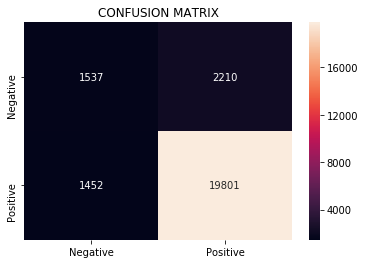

In [178]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(train_avg_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_avg_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 12.07


Text(0.5,1,'CONFUSION MATRIX')

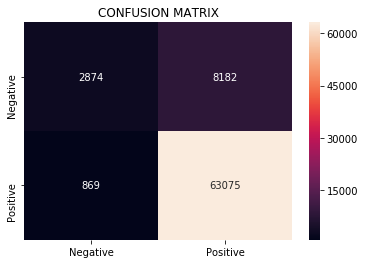

In [179]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(train_avg_w2v)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  24
Error : 14.80


Text(0.5,1,'CONFUSION MATRIX')

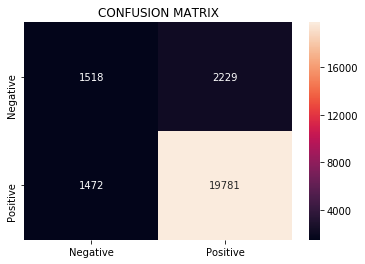

In [180]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.0009, penalty='l1');
clf.fit(train_avg_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_avg_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 12.26


Text(0.5,1,'CONFUSION MATRIX')

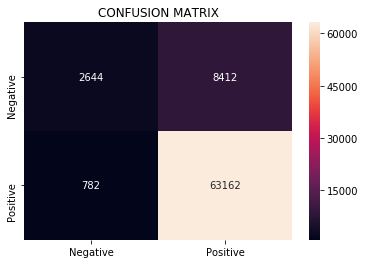

In [181]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(train_avg_w2v)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  5
Error : 15.21


Text(0.5,1,'CONFUSION MATRIX')

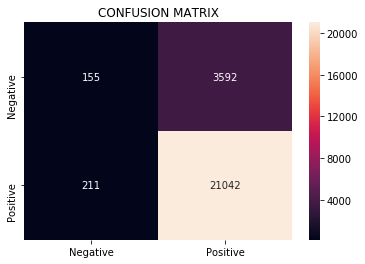

In [182]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.0001, penalty='l1');
clf.fit(train_avg_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_avg_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 14.76


Text(0.5,1,'CONFUSION MATRIX')

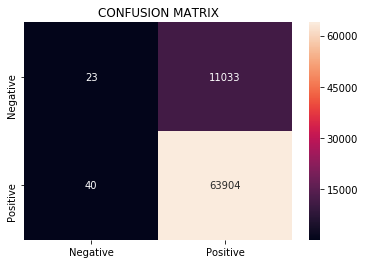

In [183]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(train_avg_w2v)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

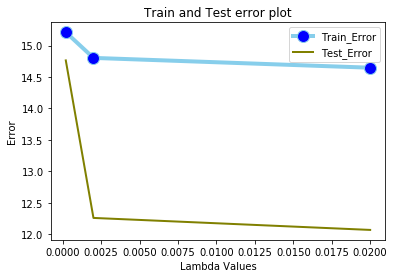

In [184]:
Train_Error, = plt.plot( lambda_list, train_error, marker='o',\
                        markerfacecolor='blue', markersize=12,\
                        color='skyblue', linewidth=4)
Test_Error,  = plt.plot( lambda_list, test_error, marker='',\
                        color='olive', linewidth=2)
plt.xlabel('Lambda Values')
plt.ylabel('Error')
plt.title('Train and Test error plot')
plt.legend([Train_Error,Test_Error], ["Train_Error","Test_Error"])
plt.show()

In [64]:
"""
This code snippet shows effect of colinearity of on weight vectors
"""
x = copy.deepcopy(train_avg_w2v)

clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(train_avg_w2v, y_train);
w = clf.coef_
a = np.transpose(np.nonzero(w))
print("Weight vector before perturbation :", end=" ")
for i,j in a[:20]:
    print("%.5f"%w[i,j], end=" ")

print("\n")

# perturbation technique start
epsilon = np.random.normal(loc=0.0, scale=0.01)
a = np.transpose(np.nonzero(x))
for i,j in a:
    x[i,j] += epsilon
# perturbation technique end

clf = LogisticRegression(C=0.001 , penalty='l1');
clf.fit(x, y_train);
w = clf.coef_
a = np.transpose(np.nonzero(w))
print("Weight vector after perturbation :", end=" ")
for i,j in a[:20]:
    print("%.5f"%w[i,j], end=" ")

# deleting the variable to free RAM
del x

Weight vector before perturbation : -0.18761 -0.35046 0.33493 0.11416 -0.08674 -0.11332 0.11148 0.12944 -0.14081 0.14100 0.25901 0.16038 0.00797 0.74318 -0.08701 0.30061 -0.25531 0.06359 0.08152 -0.08298 

Weight vector after perturbation : -0.19211 -0.35466 0.33445 0.11317 -0.08735 -0.11632 0.10879 0.13067 -0.14266 0.13978 0.26025 0.15877 0.00470 0.74036 -0.08880 0.29879 -0.25897 0.06341 0.08048 -0.08498 

In [63]:
"""
This code snippet prints top 10 important features along with there index no
"""
clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(train_avg_w2v, y_train);
w = clf.coef_
a = [i for i in sorted(enumerate(w[0]),key=lambda pair: pair[1], reverse = True) if i[1] != 0.0]
print("FeatureIndex  FeatureWeight\n")
print(*a[:10],sep = '\n')

FeatureIndex  FeatureWeight

(26, 0.743125442521408)
(37, 0.3602241152831083)
(8, 0.3348152640858897)
(29, 0.30070132251814846)
(19, 0.2590928922351227)
(43, 0.20244371107010584)
(34, 0.19416609132792062)
(20, 0.1604415531310982)
(18, 0.1410386353493387)
(45, 0.1342840935593244)


#### Observation:
* Here we have applied average word2vec to convert text to vector.
* We got hyperparameter(lambda) from GridSearchCV is 1 and from RandomizedSearchCV is 804 .
* I got best result from a model where C = 0.001, sparsity = 50 and the minimum error 13.18.
* In above models as we are reducing dimensions, so, weight vector and colinearity are not much helpful.

### b) TF IDF Word2Vec

In [11]:
"""
This code snippet converts train data from text to vectors by TF-IDF weighted Word2Vec
"""
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), analyzer = 'word')
final_tf_idf = tf_idf_vect.fit_transform(x_train)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_train_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_train_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum == 0:
        weight_sum = 1
    sent_vec /= weight_sum
    tfidf_train_vectors.append(sent_vec)
    row += 1
train_tf_idf_w2v = np.asmatrix(tfidf_train_vectors)

In [12]:
"""
This code snippet converts test data from text to vectors by TF-IDF weighted Word2Vec
"""
final_tf_idf = tf_idf_vect.transform(x_test)
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
tfidf_test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_test_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_test_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    if weight_sum == 0:
        weight_sum = 1
    sent_vec /= weight_sum
    tfidf_test_vectors.append(sent_vec)
    row += 1
test_tf_idf_w2v = np.asmatrix(tfidf_test_vectors)

In [13]:
"""
Standardize both training and test data
"""
scale = StandardScaler(with_mean = False)
train_tf_idf_w2v = scale.fit_transform(train_tf_idf_w2v)
test_tf_idf_w2v  = scale.transform(test_tf_idf_w2v)
print("Train data shape : ",train_tf_idf_w2v.shape)
print("Test data shape : ",test_tf_idf_w2v.shape)

Train data shape :  (75000, 50)
Test data shape :  (25000, 50)


In [14]:
import pickle
pickle_out = open("train_tf_idf_w2v.pkl", "wb")
pickle.dump(train_tf_idf_w2v, pickle_out)
pickle_out.close()
pickle_out = open("test_tf_idf_w2v.pkl", "wb")
pickle.dump(test_tf_idf_w2v, pickle_out)
pickle_out.close()

In [15]:
"""
This code snippet deals with GridSearchCV
"""
tuned_parameters = [{ 'C' : [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
f1_scorer = make_scorer(f1_score, pos_label="positive")
model = GridSearchCV(LogisticRegression(), tuned_parameters, scoring = f1_scorer, cv=5 )
model.fit(train_tf_idf_w2v, y_train)
print(model.best_estimator_)
print("F1 Score : ",model.score(train_tf_idf_w2v, y_train))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
F1 Score :  0.9326301693461628


In [16]:
"""
This code snippet deals with RandomizedSearchCV
"""
parameters = { 'C' : uniform(10**-2,10**2)}
f1_scorer = make_scorer(f1_score, pos_label="positive")
model = RandomizedSearchCV(LogisticRegression(), parameters, scoring = f1_scorer, cv=5 )
model.fit(train_tf_idf_w2v, y_train)
print(model.best_estimator_)
print("F1 Score : ",model.score(train_tf_idf_w2v, y_train))

LogisticRegression(C=96.38755692569153, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
F1 Score :  0.9326311829979312


Sparsity :  50
Error : 14.44


Text(0.5,1,'CONFUSION MATRIX')

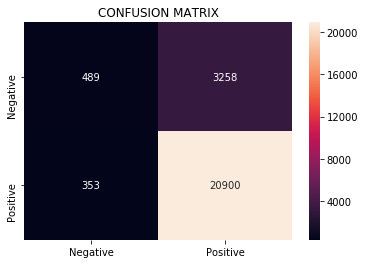

In [45]:
"""
In this code snippet finds sparsity and erorr using lamda from GridSearchCV.
"""
clf = LogisticRegression(C=0.01, penalty='l2');
clf.fit(train_tf_idf_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_tf_idf_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  46
Error : 14.49


Text(0.5,1,'CONFUSION MATRIX')

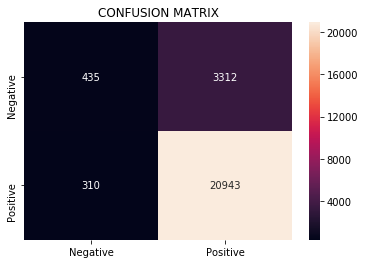

In [46]:
"""
In this code snippet finds sparsity and erorr using lamda from GridSearchCV.
"""
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(train_tf_idf_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_tf_idf_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  50
Error : 14.44


Text(0.5,1,'CONFUSION MATRIX')

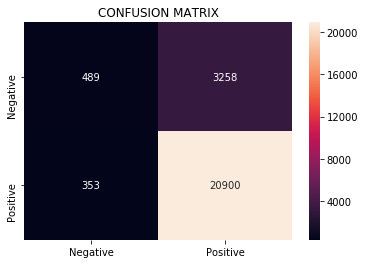

In [66]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.01, penalty='l2');
clf.fit(train_tf_idf_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_tf_idf_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

In [128]:
"""Lists to store lambda and error values"""
lambda_list = [0.02,0.002,0.0002]
train_error = []
test_error = []

Sparsity :  46
Error : 14.50


Text(0.5,1,'CONFUSION MATRIX')

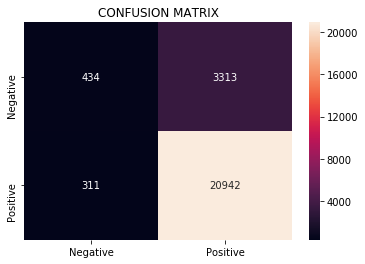

In [129]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(train_tf_idf_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_tf_idf_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 12.07


Text(0.5,1,'CONFUSION MATRIX')

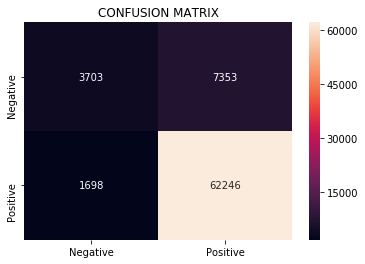

In [130]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(train_tf_idf_w2v)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  23
Error : 14.60


Text(0.5,1,'CONFUSION MATRIX')

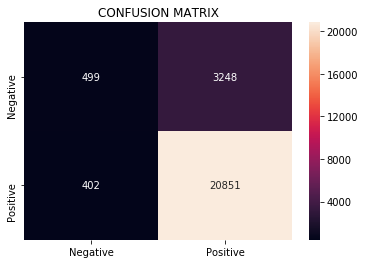

In [131]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.001, penalty='l1');
clf.fit(train_tf_idf_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_tf_idf_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 13.29


Text(0.5,1,'CONFUSION MATRIX')

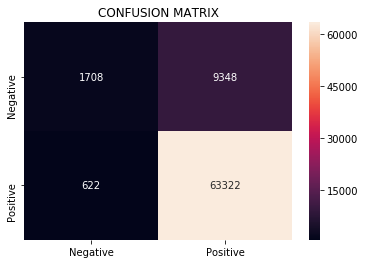

In [132]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(train_tf_idf_w2v)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Sparsity :  5
Error : 15.40


Text(0.5,1,'CONFUSION MATRIX')

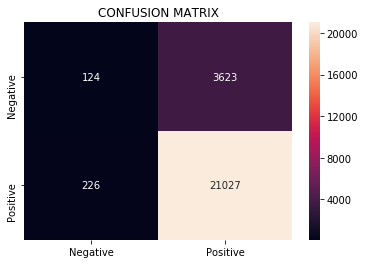

In [133]:
"""
In this code snippet finds sparsity and erorr using lamda from RandomizedSearchCV.
"""
clf = LogisticRegression(C=0.0001, penalty='l1');
clf.fit(train_tf_idf_w2v, y_train);
w = clf.coef_
print("Sparsity : ",np.count_nonzero(w))
# response prediction
pred = clf.predict(test_tf_idf_w2v)
# evaluate error
acc = accuracy_score(y_test, pred)*100
print("Error : %.2f"%(100-acc))
test_error.append(100-acc)
conf_matrix = confusion_matrix(y_test, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

Error : 14.81


Text(0.5,1,'CONFUSION MATRIX')

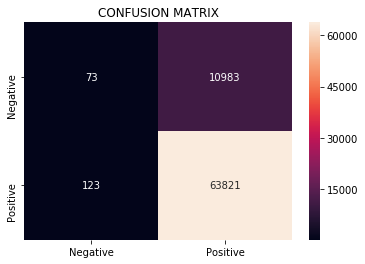

In [134]:
"""
In this code snippet finds sparsity and train erorr using lamda value from RandomizedSearchCV.
"""
# response prediction
pred = clf.predict(train_tf_idf_w2v)
# evaluate error
acc = accuracy_score(y_train, pred)*100
print("Error : %.2f"%(100-acc))
train_error.append(100-acc)
conf_matrix = confusion_matrix(y_train, pred)
confusion_matrix_df = pd.DataFrame(conf_matrix,
                                   ["Negative", "Positive"],\
                                   ["Negative", "Positive"],\
                                   dtype=int)
sns.heatmap(confusion_matrix_df, annot=True, fmt="d")
plt.title("CONFUSION MATRIX")

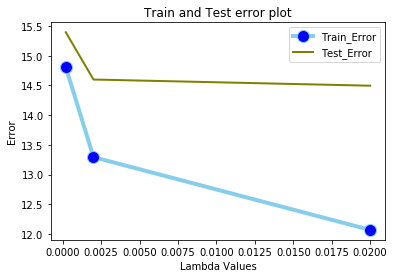

In [135]:
Train_Error, = plt.plot( lambda_list, train_error, marker='o',\
                        markerfacecolor='blue', markersize=12,\
                        color='skyblue', linewidth=4)
Test_Error,  = plt.plot( lambda_list, test_error, marker='',\
                        color='olive', linewidth=2)
plt.xlabel('Lambda Values')
plt.ylabel('Error')
plt.title('Train and Test error plot')
plt.legend([Train_Error,Test_Error], ["Train_Error","Test_Error"])
plt.show()

In [70]:
"""
This code snippet shows effect of colinearity of on weight vectors
"""
x = copy.deepcopy(train_tf_idf_w2v)

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(train_tf_idf_w2v, y_train);
w = clf.coef_
a = np.transpose(np.nonzero(w))
print("Weight vector before perturbation :", end=" ")
for i,j in a[:20]:
    print("%.5f"%w[i,j], end=" ")
    
print("\n")

# perturbation technique start
epsilon = np.random.normal(loc=0.0, scale=0.01)
a = np.transpose(np.nonzero(x))
for i,j in a:
    x[i,j] += epsilon
# perturbation technique end

clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(x, y_train);
w = clf.coef_
a = np.transpose(np.nonzero(w))
print("Weight vector after perturbation :", end=" ")
for i,j in a[:20]:
    print("%.5f"%w[i,j], end=" ")

# deleting the variable to free RAM
del x

Weight vector before perturbation : 0.08694 -0.38302 0.22105 0.24121 -0.11721 0.17038 -0.42431 0.65010 -0.20882 0.33386 -0.25133 -0.30001 0.19975 -0.16763 0.48161 -0.05545 -0.40127 0.23059 0.42992 0.12824 

Weight vector after perturbation : 0.08488 -0.38228 0.22008 0.23916 -0.11353 0.17034 -0.42079 0.64864 -0.21079 0.33565 -0.25262 -0.29638 0.20379 -0.16737 0.47199 -0.05404 -0.39701 0.22953 0.42577 0.13604 

In [69]:
"""
This code snippet prints top 10 important features along with there index no
"""
clf = LogisticRegression(C=0.01, penalty='l1');
clf.fit(train_tf_idf_w2v, y_train);
w = clf.coef_
a = [i for i in sorted(enumerate(w[0]),key=lambda pair: pair[1], reverse = True) if i[1] != 0.0]
print("FeatureIndex  FeatureWeight\n")
print(*a[:10],sep = '\n')

FeatureIndex  FeatureWeight

(26, 0.8190866591633971)
(8, 0.6500719981139358)
(43, 0.49860403477019305)
(37, 0.4951671255900718)
(15, 0.48158254020543895)
(19, 0.4298810359667908)
(31, 0.3793480537526893)
(29, 0.3401697634786569)
(34, 0.34003910873861687)
(10, 0.33380820007262607)


#### Observation:
* Here we have applied TF IDF word2vec to convert text to vector.
* We got hyperparameter(lambda) from GridSearchCV is 100 and from RandomizedSearchCV is 96.38.
* I got best result from a model where C = 0.01, sparsity = 46 and the minimum error 14.50.
* In above models as we are reducing dimensions, so, weight vector and colinearity are not much helpful.

In [ ]:
"""
This code snippet prepares a table that contains
end results of diffrent models that we have used.
"""
table = PrettyTable()
table.field_names = ['Model','Best C','Regularizer','Lowest Error','Sparsity']
table.add_row(['BOW',0.02,'L1',8.31,6351])
table.add_row(['TF IDF',0.016,'L1',8.21,32487])
table.add_row(['AVG word2vec',0.001,'L2',13.48,50])
table.add_row(['TF IDF word2vec',0.01,'L1',14.50,46])

## Conclusion :
1. From the above analysis with 100k sample of data I got that TF IDF is the best with less error 8.21% .
2. Colinearity is not affecting much to the features.
3. By applying TF_IDF vectorizer, we got a very less error and higher accuracy from Logistic Regression.
4. Until now Logistic Regression is the best classification technique that I have learned.
5. LR is labeling positive and negative points quite impressively with such a little and imbalanced dataset.

In [3]:
print(table)

+-----------------+--------+-------------+--------------+----------+
|      Model      | Best C | Regularizer | Lowest Error | Sparsity |
+-----------------+--------+-------------+--------------+----------+
|       BOW       |  0.02  |      L1     |     8.31     |   6351   |
|      TF IDF     | 0.016  |      L1     |     8.21     |  32487   |
|   AVG word2vec  | 0.001  |      L2     |    13.48     |    50    |
| TF IDF word2vec |  0.01  |      L1     |     14.5     |    46    |
+-----------------+--------+-------------+--------------+----------+
